In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
import os

# Paths (relative to current working directory)
img_dir = 'images'
mask_dir = 'annotations/trimaps'
xml_dir = 'annotations/xmls'
split_file = 'annotations/trainval.txt'

# Read first image name from split
with open(split_file, 'r') as f:
    file_id = f.readline().strip().split(' ')[0]  # e.g., "Abyssinian_1"

print("Sample filename:", file_id)


Sample filename: Abyssinian_100


In [3]:
from PIL import Image
import xml.etree.ElementTree as ET

# Construct full file paths
img_path = os.path.join(img_dir, file_id + '.jpg')
mask_path = os.path.join(mask_dir, file_id + '.png')
xml_path = os.path.join(xml_dir, file_id + '.xml')

# Load image and mask
image = Image.open(img_path).convert('RGB')
mask = Image.open(mask_path)

# Parse bounding box from XML
tree = ET.parse(xml_path)
root = tree.getroot()
bbox = root.find('object').find('bndbox')
xmin = int(bbox.find('xmin').text)
ymin = int(bbox.find('ymin').text)
xmax = int(bbox.find('xmax').text)
ymax = int(bbox.find('ymax').text)

print("Image size:", image.size)
print("BBox:", (xmin, ymin, xmax, ymax))
print("Mask mode:", mask.mode)


Image size: (394, 500)
BBox: (151, 71, 335, 267)
Mask mode: L


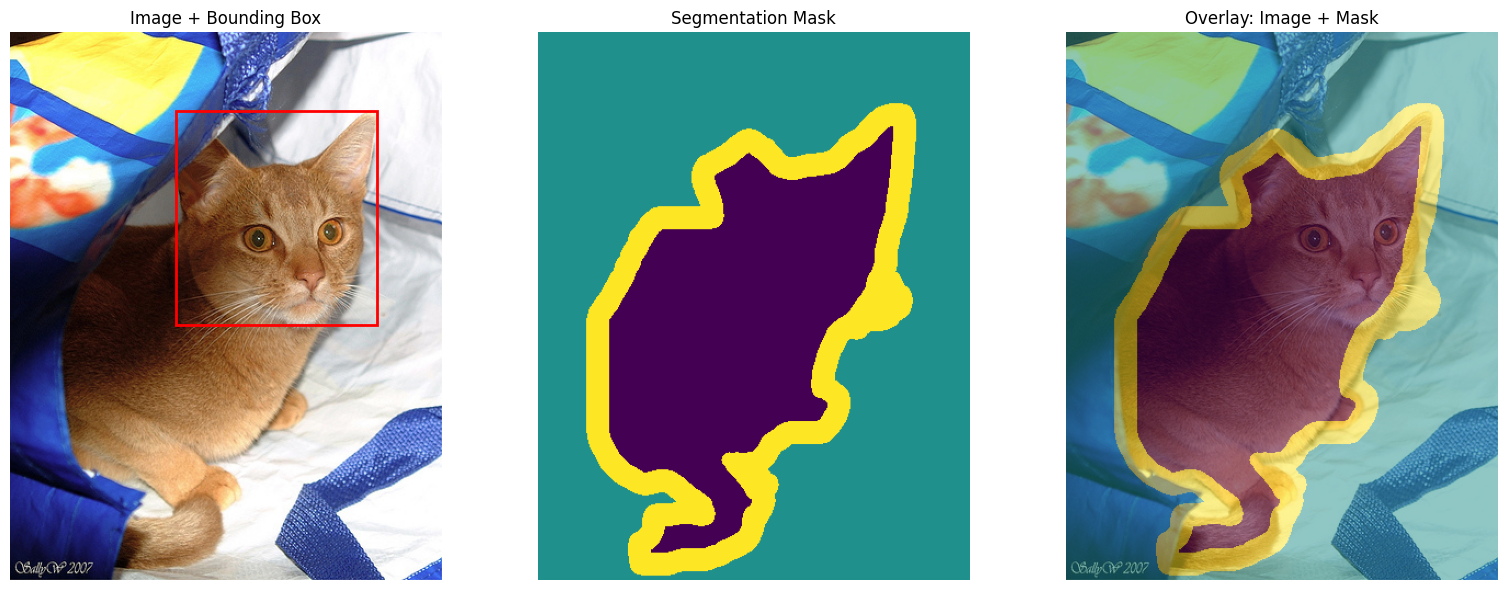

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Plot all together
fig, axs = plt.subplots(1, 3, figsize=(16, 6))

# 1. Image with BBox
axs[0].imshow(image)
axs[0].add_patch(
    patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                      linewidth=2, edgecolor='red', facecolor='none')
)
axs[0].set_title("Image + Bounding Box")
axs[0].axis('off')

# 2. Segmentation Mask
axs[1].imshow(mask, cmap='viridis')
axs[1].set_title("Segmentation Mask")
axs[1].axis('off')

# 3. Overlay
axs[2].imshow(image)
axs[2].imshow(np.array(mask), cmap='viridis', alpha=0.5)
axs[2].set_title("Overlay: Image + Mask")
axs[2].axis('off')

plt.tight_layout()
plt.show()


In [5]:
import os
import random
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class OxfordPetsDataset(Dataset):
    def __init__(self, root_dir, split='train', mode='classification', transform=None, split_ratio=0.8, seed=42):
        assert mode == 'classification', "This version supports classification only for now."

        self.root_dir = root_dir
        self.mode = mode
        self.split = split

        # Get all image files
        all_files = sorted([f[:-4] for f in os.listdir(os.path.join(root_dir, 'images')) if f.endswith('.jpg')])

        # Split
        random.seed(seed)
        random.shuffle(all_files)
        split_idx = int(len(all_files) * split_ratio)
        self.image_ids = all_files[:split_idx] if split == 'train' else all_files[split_idx:]

        # Class label mapping
        self.class_names = sorted(list(set([img_id.rsplit('_', 1)[0] for img_id in all_files])))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.class_names)}

        # Default transforms
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.root_dir, 'images', f'{img_id}.jpg')

        image = Image.open(img_path).convert('RGB')
        class_name = img_id.rsplit('_', 1)[0]
        label = self.class_to_idx[class_name]

        if self.transform:
            image = self.transform(image)

        return image, label


In [6]:
dataset = OxfordPetsDataset(root_dir='.', split='train')
image, label = dataset[0]
print(f"Image shape: {image.shape}")
print(f"Label index: {label}, Label name: {dataset.class_names[label]}")


Image shape: torch.Size([3, 224, 224])
Label index: 31, Label name: samoyed


In [7]:
from torch.utils.data import DataLoader

# Create train and test datasets
train_dataset = OxfordPetsDataset(root_dir='.', split='train', mode='classification')
test_dataset = OxfordPetsDataset(root_dir='.', split='test', mode='classification')

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


In [8]:
# Inspect one batch
images, labels = next(iter(train_loader))
print(f"Image batch shape: {images.shape}")  # [32, 3, 224, 224]
print(f"Label batch shape: {labels.shape}")  # [32]


Image batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: torch.Size([32])
